In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
# ---- STEP 1: Prepare data ----
match_points = [0, 0, 1, 0, 1, 3, 1, 3, 3, 3, 1,
                 3, 3, 3, 3, 3, 1, 3, 0, 3, 1, 3]
n = len(match_points)

# Map match outcomes to class indices (needed for Categorical)
points_map = {0: 0, 1: 1, 3: 2}
match_classes = np.array([points_map[pt] for pt in match_points])
n_categories = 3

In [11]:
# ---- STEP 2: Define Bayesian model ----
with pm.Model() as model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=n)
    p1 = pm.Dirichlet("p1", a=np.ones(n_categories))
    p2 = pm.Dirichlet("p2", a=np.ones(n_categories))

    p_all = pm.math.stack([p1, p2])
    selector = (np.arange(n) >= tau).astype("int32")
    p = p_all[selector]

    obs = pm.Categorical("obs", p=p, observed=match_classes)
    trace = pm.sample(3000, tune=1000, target_accept=0.95, random_seed=42)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [p1, p2]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 27 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


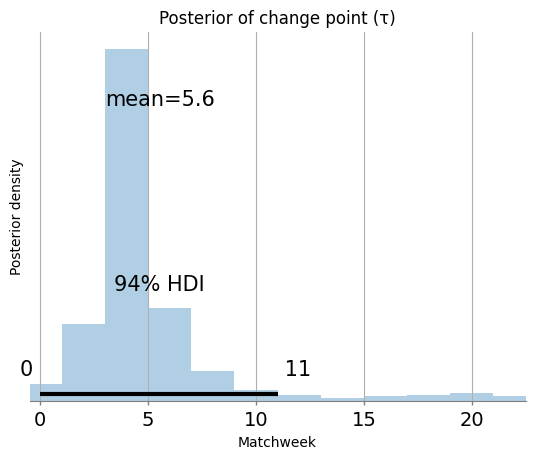

In [ ]:
# ---- STEP 3: Visualize the change point ----
az.plot_posterior(trace, var_names=["tau"])
plt.title("Posterior of change point (τ)")
plt.xlabel("Matchweek")
plt.ylabel("Posterior density")
plt.grid(True)
plt.show()

In [19]:
# ---- STEP 4: Extract and reshape samples ----
p1_samples = trace.posterior["p1"].values.reshape(-1, 3)  # (n_samples, 3)
p2_samples = trace.posterior["p2"].values.reshape(-1, 3)
tau_samples = trace.posterior["tau"].values.flatten()   

In [20]:
# ---- STEP 5: Compute mean outcome probabilities ----
# Get the samples where tau is before/after the halfway point
cut_point = 6
before_mask = tau_samples <= cut_point
after_mask = tau_samples > cut_point

# Mean outcome probabilities
p1_mean = p1_samples[before_mask].mean(axis=0)
p2_mean = p2_samples[after_mask].mean(axis=0)


In [21]:
# ---- STEP 6: Print results ----
index_to_points = {0: "0 points", 1: "1 point", 2: "3 points"}

print("Estimated outcome probabilities BEFORE the change point:")
for i, p in enumerate(p1_mean):
    print(f"  {index_to_points[i]}: {p:.3f}")

print("\nEstimated outcome probabilities AFTER the change point:")
for i, p in enumerate(p2_mean):
    print(f"  {index_to_points[i]}: {p:.3f}")

Estimated outcome probabilities BEFORE the change point:
  0 points: 0.525
  1 point: 0.320
  3 points: 0.155

Estimated outcome probabilities AFTER the change point:
  0 points: 0.141
  1 point: 0.246
  3 points: 0.613


Two change points

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [tau1]
>>Metropolis: [tau2]
>NUTS: [p1, p2, p3]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


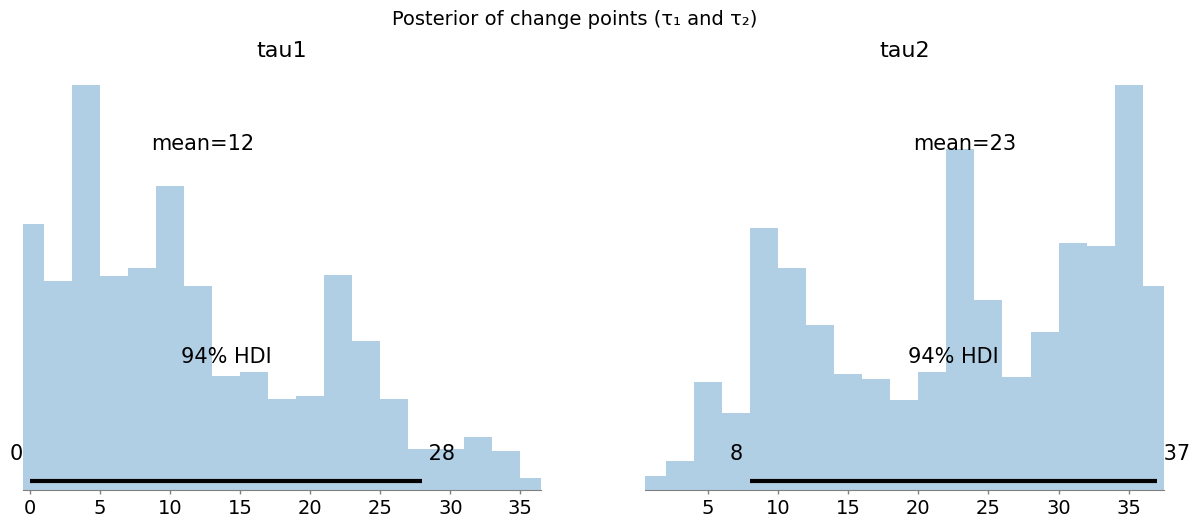

In [25]:
# ---- STEP 1: Prepare data ----
match_points = [0, 3, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 0, 3,
                3, 0, 3, 1, 3, 3, 0, 0, 0, 3, 3, 1, 3, 3,
                3, 3, 3, 1, 3, 0, 0, 3, 1, 3]
n = len(match_points)

# Map match outcomes to class indices
points_map = {0: 0, 1: 1, 3: 2}
match_classes = np.array([points_map[pt] for pt in match_points])
n_categories = 3

# ---- STEP 2: Define Bayesian model with 2 change points ----
with pm.Model() as model_2cp:
    # Define two change points: tau1 < tau2
    tau1 = pm.DiscreteUniform("tau1", lower=0, upper=n-2)
    tau2 = pm.DiscreteUniform("tau2", lower=1, upper=n-1)

    # Enforce constraint tau1 < tau2 via potential
    pm.Potential("order_constraint", pm.math.switch(tau1 < tau2, 0, -np.inf))

    # Outcome probabilities for three segments
    p1 = pm.Dirichlet("p1", a=np.ones(n_categories))
    p2 = pm.Dirichlet("p2", a=np.ones(n_categories))
    p3 = pm.Dirichlet("p3", a=np.ones(n_categories))

    # For each matchweek, dynamically assign p1, p2, or p3
    p = []
    for i in range(n):
        p_i = pm.math.switch(i < tau1, p1,
               pm.math.switch(i < tau2, p2, p3))
        p.append(p_i)
    p = pm.math.stack(p)

    # Observed outcomes
    obs = pm.Categorical("obs", p=p, observed=match_classes)

    # Sample from posterior
    trace_2cp = pm.sample(3000, tune=1000, target_accept=0.95, random_seed=42)

# ---- STEP 3: Posterior plot ----
az.plot_posterior(trace_2cp, var_names=["tau1", "tau2"])
plt.suptitle("Posterior of change points (τ₁ and τ₂)", fontsize=14)
plt.show()

numeric model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 21 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


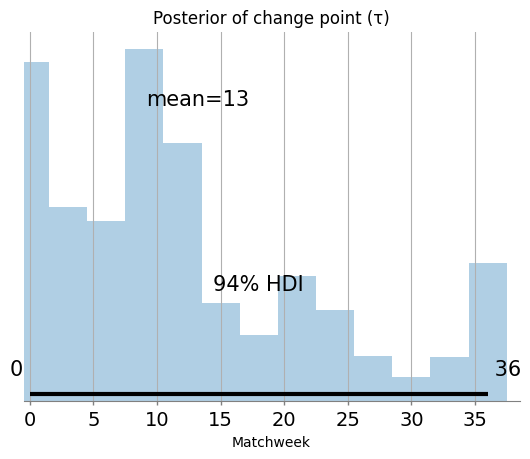

Estimated mean points BEFORE change point: 1.008 ± 0.561
Estimated mean points AFTER change point: 1.764 ± 0.413


In [34]:
# ---- STEP 1: Prepare data ----
match_points = np.array([0, 3, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 0, 3,
                         3, 0, 3, 1, 3, 3, 0, 0, 0, 3, 3, 1, 3, 3,
                         3, 3, 3, 1, 3, 0, 0, 3, 1, 3])
n = len(match_points)

# ---- STEP 2: Define Bayesian model ----
with pm.Model() as model:
    # Change point index (tau)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n)
    
    # Mean points before and after change point
    mu1 = pm.Normal("mu1", mu=1, sigma=1)
    mu2 = pm.Normal("mu2", mu=1, sigma=1)
    
    # Standard deviation before and after (to capture variability)
    sigma1 = pm.HalfNormal("sigma1", sigma=1)
    sigma2 = pm.HalfNormal("sigma2", sigma=1)
    
    # Construct mean and sigma vector for each observation based on tau
    mu = pm.math.switch(np.arange(n) < tau, mu1, mu2)
    sigma = pm.math.switch(np.arange(n) < tau, sigma1, sigma2)

    
    # Likelihood: points per match ~ Normal(mu, sigma)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=match_points)
    
    # Sample
    trace = pm.sample(3000, tune=1000, target_accept=0.95, random_seed=42,
                      idata_kwargs={"log_likelihood": True})

# ---- STEP 3: Visualize the change point ----
az.plot_posterior(trace, var_names=["tau"])
plt.title("Posterior of change point (τ)")
plt.xlabel("Matchweek")
plt.grid(True)
plt.show()

# ---- STEP 4: Print estimated mean points before and after change point ----
mu1_samples = trace.posterior["mu1"].values.flatten()
mu2_samples = trace.posterior["mu2"].values.flatten()

print(f"Estimated mean points BEFORE change point: {mu1_samples.mean():.3f} ± {mu1_samples.std():.3f}")
print(f"Estimated mean points AFTER change point: {mu2_samples.mean():.3f} ± {mu2_samples.std():.3f}")


In [31]:
tau_samples = trace.posterior["tau"].values.flatten()
tau_mode = np.bincount(tau_samples).argmax()
print(f"Most probable change point (mode): {tau_mode}")

Most probable change point (mode): 11


In [35]:
with pm.Model() as model_no_cp:
    mu = pm.Normal("mu", mu=1, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=match_points)
    
    trace_no_cp = pm.sample(3000, tune=1000, target_accept=0.95, random_seed=42,
                            idata_kwargs={"log_likelihood": True})


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 15 seconds.


In [36]:
# Convert traces to InferenceData if not already
idata_with_cp = trace  # your current model
idata_no_cp = trace_no_cp

# Compare using LOO
comparison = az.compare(
    {"with_cp": trace, "no_cp": trace_no_cp},
    method="BB-pseudo-BMA",
    ic="loo"
)
print(comparison)



         rank   elpd_loo     p_loo  elpd_diff    weight        se       dse  \
no_cp       0 -67.295670  1.044527   0.000000  0.682029  2.019970  0.000000   
with_cp     1 -68.389114  4.145058   1.093444  0.317971  1.243085  1.600913   

         warning scale  
no_cp      False   log  
with_cp     True   log  


/Users/rolandkovacs/Documents/GitHub/bayesian_football/venv/lib/python3.9/site-packages/arviz/stats/stats.py:1024: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/rolandkovacs/Documents/GitHub/bayesian_football/venv/lib/python3.9/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


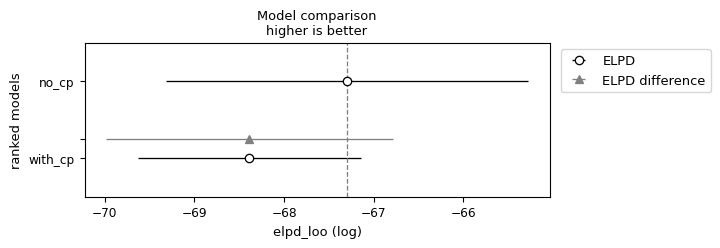

In [37]:
az.plot_compare(comparison)
plt.show()

In [43]:
# Credible interval (e.g., 95%) for tau
hdi_tau = az.hdi(trace.posterior["tau"], hdi_prob=0.8)
print(f"95% credible interval for tau: {hdi_tau.values}")


95% credible interval for tau: <bound method Mapping.values of <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    tau      (hdi) float64 16B 0.0 23.0>


In [39]:
tau_samples = trace.posterior["tau"].values.flatten()
tau_mode = np.bincount(tau_samples).argmax()
prob_around_mode = np.mean((tau_samples >= tau_mode - 1) & (tau_samples <= tau_mode + 1))
print(f"Probability tau is within ±1 of mode ({tau_mode}): {prob_around_mode:.2f}")


Probability tau is within ±1 of mode (11): 0.19


numeric model more change points

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [tau1]
>>Metropolis: [tau2]
>NUTS: [mu1, mu2, mu3, sigma1, sigma2, sigma3]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1092 seconds.
There were 1742 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


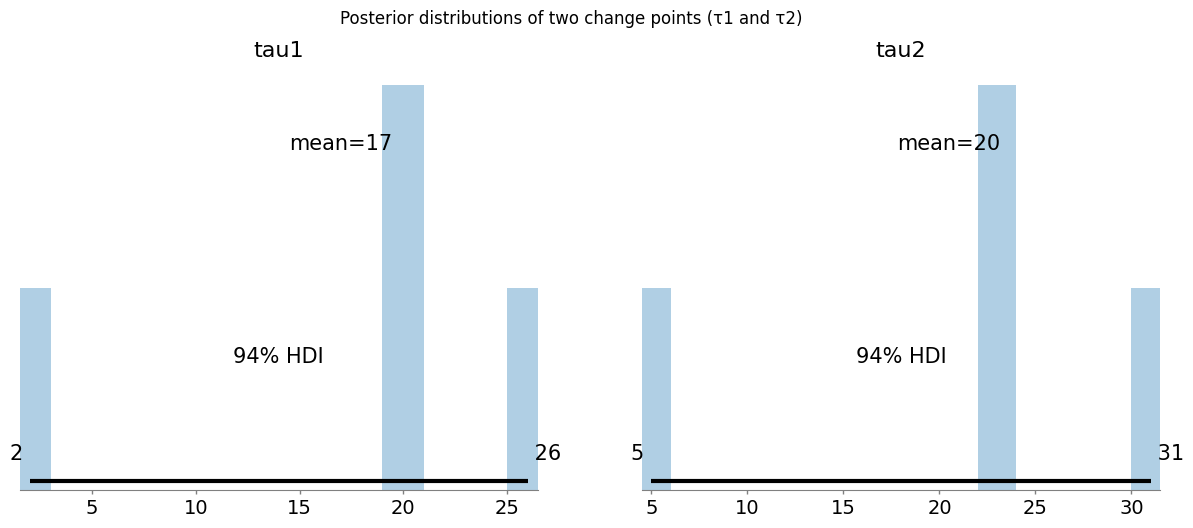

Estimated mean points Segment 1 (before τ1): 1.222 ± 0.182
Estimated mean points Segment 2 (between τ1 and τ2): 0.750 ± 1.299
Estimated mean points Segment 3 (after τ2): 1.897 ± 0.290


In [44]:
# ---- STEP 1: Prepare data ----
match_points = np.array([0, 3, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 0, 3,
                         3, 0, 3, 1, 3, 3, 0, 0, 0, 3, 3, 1, 3, 3,
                         3, 3, 3, 1, 3, 0, 0, 3, 1, 3])
n = len(match_points)

# ---- STEP 2: Define Bayesian model with two change points ----
with pm.Model() as model_2cp:
    # Two change points tau1 and tau2, ordered so tau1 < tau2
    tau1 = pm.DiscreteUniform("tau1", lower=0, upper=n-2)
    tau2 = pm.DiscreteUniform("tau2", lower=tau1+1, upper=n-1)
    
    # Means and stddevs for three segments
    mu1 = pm.Normal("mu1", mu=1, sigma=1)
    mu2 = pm.Normal("mu2", mu=1, sigma=1)
    mu3 = pm.Normal("mu3", mu=1, sigma=1)

    sigma1 = pm.HalfNormal("sigma1", sigma=1)
    sigma2 = pm.HalfNormal("sigma2", sigma=1)
    sigma3 = pm.HalfNormal("sigma3", sigma=1)

    # For each data point, assign mu and sigma depending on segment
    idxs = np.arange(n)
    
    mu = pm.math.switch(idxs < tau1, mu1,
           pm.math.switch(idxs < tau2, mu2, mu3))
    
    sigma = pm.math.switch(idxs < tau1, sigma1,
              pm.math.switch(idxs < tau2, sigma2, sigma3))
    
    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=match_points)
    
    # Sampling
    trace_2cp = pm.sample(3000, tune=1000, target_accept=0.95, random_seed=42,
                            idata_kwargs={"log_likelihood": True})

# ---- STEP 3: Diagnostics and visualization ----
az.plot_posterior(trace_2cp, var_names=["tau1", "tau2"])
plt.suptitle("Posterior distributions of two change points (τ1 and τ2)")
plt.show()

# Estimated means per segment
mu1_samples = trace_2cp.posterior["mu1"].values.flatten()
mu2_samples = trace_2cp.posterior["mu2"].values.flatten()
mu3_samples = trace_2cp.posterior["mu3"].values.flatten()

print(f"Estimated mean points Segment 1 (before τ1): {mu1_samples.mean():.3f} ± {mu1_samples.std():.3f}")
print(f"Estimated mean points Segment 2 (between τ1 and τ2): {mu2_samples.mean():.3f} ± {mu2_samples.std():.3f}")
print(f"Estimated mean points Segment 3 (after τ2): {mu3_samples.mean():.3f} ± {mu3_samples.std():.3f}")


In [45]:
# Convert traces to InferenceData if not already
idata_with_cp = trace_2cp  # your current model
idata_no_cp = trace_no_cp

# Compare using LOO
comparison = az.compare(
    {"with_cp": trace, "no_cp": trace_no_cp},
    method="BB-pseudo-BMA",
    ic="loo"
)
print(comparison)

         rank   elpd_loo     p_loo  elpd_diff   weight        se       dse  \
no_cp       0 -67.295670  1.044527   0.000000  0.67398  2.021413  0.000000   
with_cp     1 -68.389114  4.145058   1.093444  0.32602  1.288404  1.600913   

         warning scale  
no_cp      False   log  
with_cp     True   log  


/Users/rolandkovacs/Documents/GitHub/bayesian_football/venv/lib/python3.9/site-packages/arviz/stats/stats.py:1024: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/rolandkovacs/Documents/GitHub/bayesian_football/venv/lib/python3.9/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


gradual

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, k, mu1, mu2, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 97 seconds.


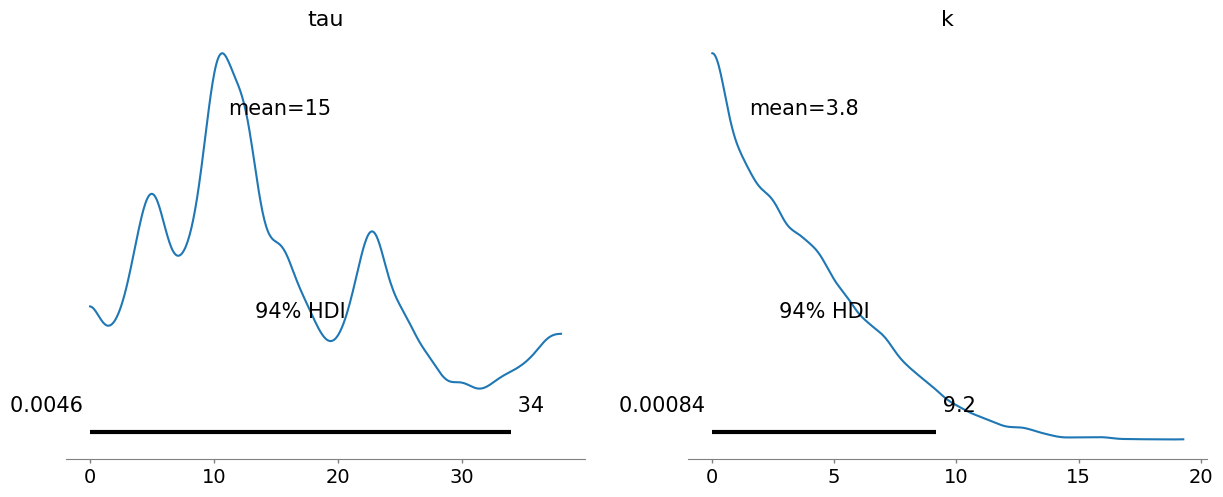

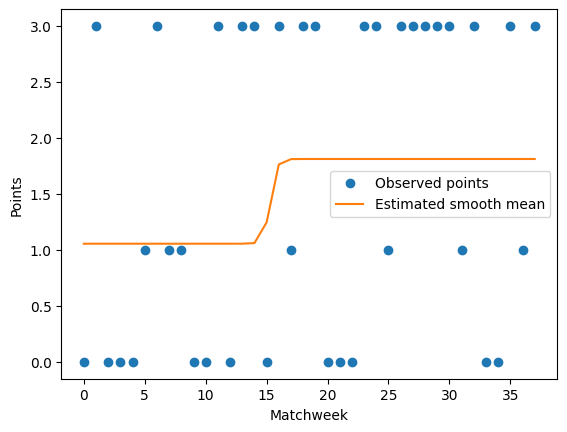

In [46]:

match_points = np.array([0, 3, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 0, 3,
                         3, 0, 3, 1, 3, 3, 0, 0, 0, 3, 3, 1, 3, 3,
                         3, 3, 3, 1, 3, 0, 0, 3, 1, 3])
n = len(match_points)
idxs = np.arange(n)

with pm.Model() as model_smooth_cp:
    # Center of change (continuous in [0, n])
    tau = pm.Uniform("tau", lower=0, upper=n)
    
    # Steepness of transition (positive, controls smoothness)
    k = pm.HalfNormal("k", sigma=5)
    
    # Means before and after
    mu1 = pm.Normal("mu1", mu=1, sigma=1)
    mu2 = pm.Normal("mu2", mu=1, sigma=1)
    
    # Standard deviation
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Logistic transition weights for each time point
    w = 1 / (1 + pm.math.exp(-k * (idxs - tau)))
    
    # Smoothly varying mean
    mu = mu1 + w * (mu2 - mu1)
    
    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=match_points)
    
    # Sample
    trace_smooth = pm.sample(3000, tune=1000, target_accept=0.95, random_seed=42,
                            idata_kwargs={"log_likelihood": True})

# Plot posterior for tau and k
az.plot_posterior(trace_smooth, var_names=["tau", "k"])
plt.show()

# Plot data with smooth mean estimate
mu_samples = trace_smooth.posterior["mu1"].values + \
             trace_smooth.posterior["mu2"].values - trace_smooth.posterior["mu1"].values

tau_samples = trace_smooth.posterior["tau"].values.flatten()
k_samples = trace_smooth.posterior["k"].values.flatten()

# Mean smooth mean curve
w_mean = 1 / (1 + np.exp(-k_samples.mean() * (idxs - tau_samples.mean())))
mu_mean = trace_smooth.posterior["mu1"].values.mean() + w_mean * (trace_smooth.posterior["mu2"].values.mean() - trace_smooth.posterior["mu1"].values.mean())

plt.plot(idxs, match_points, "o", label="Observed points")
plt.plot(idxs, mu_mean, label="Estimated smooth mean")
plt.xlabel("Matchweek")
plt.ylabel("Points")
plt.legend()
plt.show()


In [48]:

# Compare using LOO
comparison = az.compare(
    {"with_cp": trace_smooth, "no_cp": trace_no_cp},
    method="BB-pseudo-BMA",
    ic="loo"
)
print(comparison)

         rank   elpd_loo     p_loo  elpd_diff    weight        se       dse  \
with_cp     0 -67.290671  2.822301   0.000000  0.508238  1.724566  0.000000   
no_cp       1 -67.295670  1.044527   0.004999  0.491762  1.218203  1.260525   

         warning scale  
with_cp    False   log  
no_cp      False   log  


In [ ]:
# Credible interval (e.g., 95%) for tau
hdi_tau = az.hdi(trace.posterior["tau"], hdi_prob=0.8)
print(f"95% credible interval for tau: {hdi_tau.values}")

In [ ]:
tau_samples = trace.posterior["tau"].values.flatten()
tau_mode = np.bincount(tau_samples).argmax()
prob_around_mode = np.mean((tau_samples >= tau_mode - 1) & (tau_samples <= tau_mode + 1))
print(f"Probability tau is within ±1 of mode ({tau_mode}): {prob_around_mode:.2f}")


Time-varying mean via Gaussian random walk

/Users/rolandkovacs/Documents/GitHub/bayesian_football/venv/lib/python3.9/site-packages/pymc/distributions/timeseries.py:298: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, sigma_rw, mu]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 149 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_dataarray()` method.

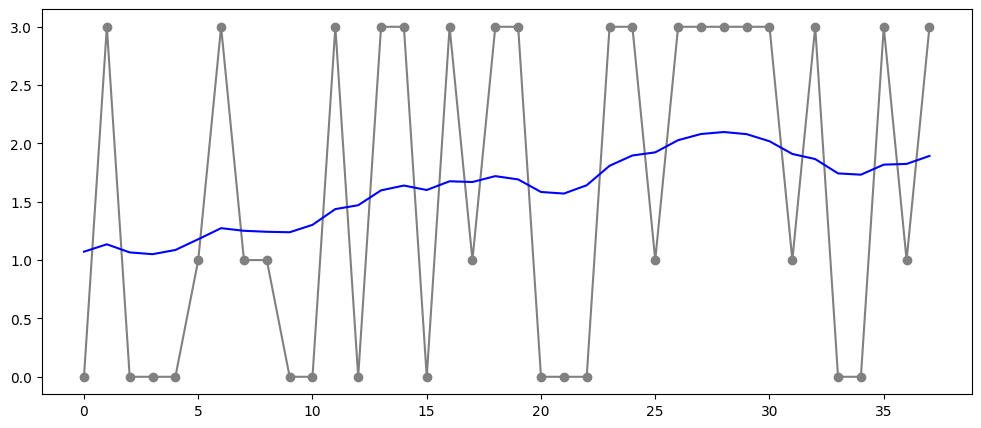

In [49]:
# ---- STEP 1: Prepare data ----
match_points = np.array([0, 3, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 0, 3,
                         3, 0, 3, 1, 3, 3, 0, 0, 0, 3, 3, 1, 3, 3,
                         3, 3, 3, 1, 3, 0, 0, 3, 1, 3])
n = len(match_points)

# ---- STEP 2: Define Bayesian model ----
with pm.Model() as model:
    # Observation noise (how variable actual outcomes are)
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=1.0)
    
    # Random walk step size (how much the mean can shift from one match to the next)
    sigma_rw = pm.HalfNormal("sigma_rw", sigma=1.0)
    
    # Evolving mean points per match: Gaussian Random Walk
    mu = pm.GaussianRandomWalk("mu", sigma=sigma_rw, shape=n)
    
    # Likelihood: actual match points ~ N(mu[t], sigma_obs)
    obs = pm.Normal("obs", mu=mu, sigma=sigma_obs, observed=match_points)

    # Sampling
    trace = pm.sample(3000, tune=1000, target_accept=0.95, random_seed=42)

# ---- STEP 3: Plot results ----
# Extract mean trajectory and HDI
mu_mean = trace.posterior["mu"].mean(dim=("chain", "draw")).values
mu_hdi = az.hdi(trace.posterior["mu"], hdi_prob=0.95)



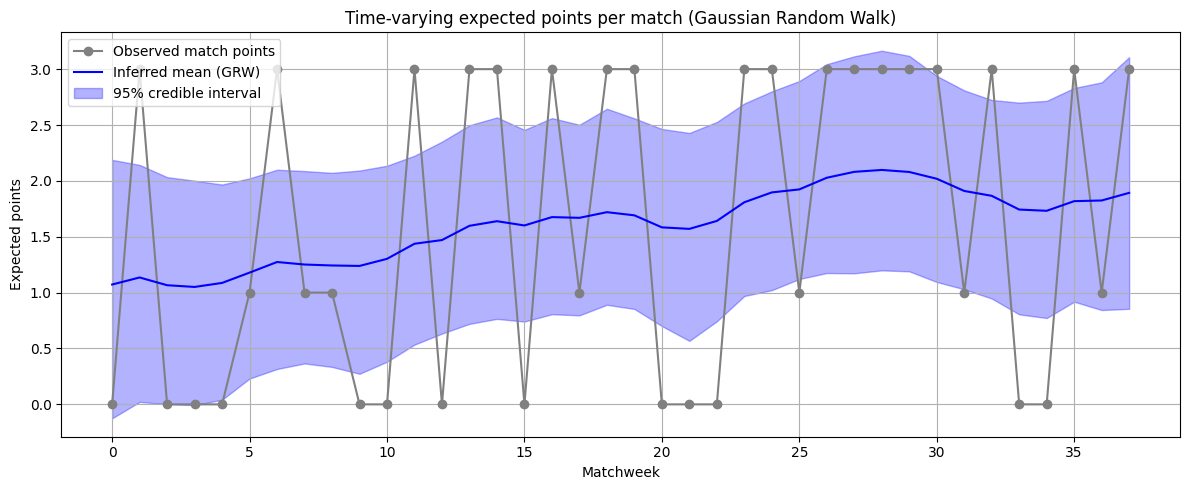

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_obs  1.329  0.167   1.021    1.642      0.002    0.002    4246.0   
sigma_rw   0.263  0.191   0.024    0.611      0.013    0.009     174.0   

           ess_tail  r_hat  
sigma_obs    4396.0   1.00  
sigma_rw      230.0   1.02  


In [53]:
# ---- STEP 3: Plot Results ----
# Get posterior for time-varying mean
mu_post = trace.posterior["mu"]

# Compute mean of the posterior
mu_mean = mu_post.mean(dim=("chain", "draw")).values

# Compute 95% HDI (credible interval)
mu_hdi = az.hdi(mu_post, hdi_prob=0.95)
mu_hdi_lower = mu_hdi.sel(hdi="lower").to_array().values[0]
mu_hdi_upper = mu_hdi.sel(hdi="higher").to_array().values[0]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(match_points, "o-", color="gray", label="Observed match points")
plt.plot(mu_mean, color="blue", label="Inferred mean (GRW)")
plt.fill_between(np.arange(n), mu_hdi_lower, mu_hdi_upper, color="blue", alpha=0.3, label="95% credible interval")
plt.xlabel("Matchweek")
plt.ylabel("Expected points")
plt.title("Time-varying expected points per match (Gaussian Random Walk)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- STEP 4: Optional Summary ----
print(az.summary(trace, var_names=["sigma_obs", "sigma_rw"]))

All turning points: [1, 3, 6, 9, 14, 15, 16, 17, 18, 21, 28, 34]
Credible turning points: []


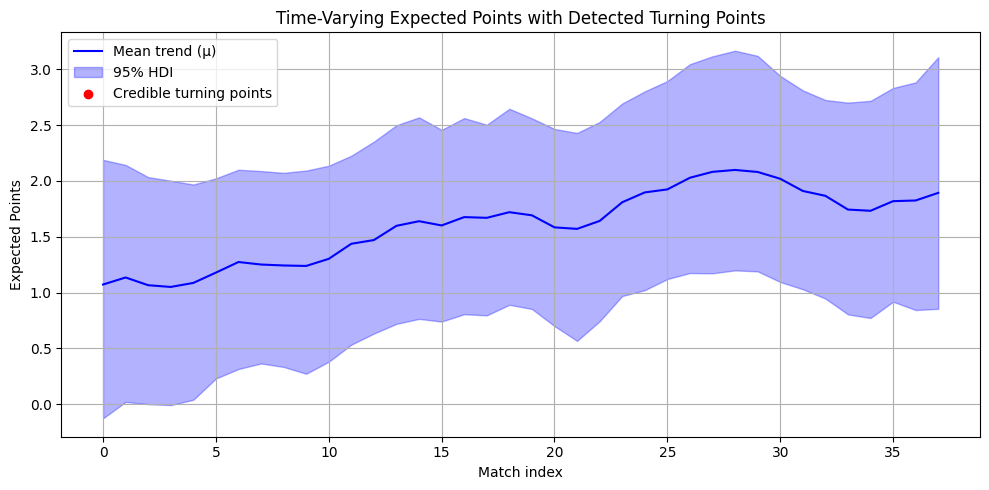

In [56]:
# Step 1: Extract posterior mean and HDI
mu_posterior = trace.posterior["mu"]
mu_mean = mu_posterior.mean(dim=("chain", "draw")).values
mu_hdi = az.hdi(mu_posterior, hdi_prob=0.95)

# Convert HDI bounds to NumPy arrays
mu_hdi_lower = mu_hdi.sel(hdi="lower").to_array().values[0]
mu_hdi_upper = mu_hdi.sel(hdi="higher").to_array().values[0]

# Step 2: Compute first differences of mean
mu_diff = np.diff(mu_mean)
signs = np.sign(mu_diff)

# Step 3: Find slope direction changes (turning points)
turning_points = np.where(np.diff(signs) != 0)[0] + 1

# Step 4: Filter turning points based on non-overlapping HDIs
credible_turning_points = []
for tp in turning_points:
    if tp <= 1 or tp >= len(mu_mean) - 2:
        continue
    prev_upper = mu_hdi_upper[tp - 1]
    next_lower = mu_hdi_lower[tp + 1]
    if prev_upper < next_lower or mu_hdi_upper[tp + 1] < mu_hdi_lower[tp - 1]:
        credible_turning_points.append(tp)

# Output results
print("All turning points:", turning_points.tolist())
print("Credible turning points:", credible_turning_points)

# Step 5: Plot
x = np.arange(len(mu_mean))
plt.figure(figsize=(10, 5))
plt.plot(x, mu_mean, label="Mean trend (μ)", color="blue")
plt.fill_between(x, mu_hdi_lower, mu_hdi_upper, color="blue", alpha=0.3, label="95% HDI")
plt.scatter(credible_turning_points, mu_mean[credible_turning_points], color="red", zorder=5, label="Credible turning points")
plt.title("Time-Varying Expected Points with Detected Turning Points")
plt.xlabel("Match index")
plt.ylabel("Expected Points")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Hidden Markov Model (HMM)

In [ ]:
# ---- STEP 1: Observed data ----
match_points = np.array([0, 3, 0, 0, 0, 1, 3, 1, 1, 0, 0, 3, 0, 3,
                         3, 0, 3, 1, 3, 3, 0, 0, 0, 3, 3, 1, 3, 3,
                         3, 3, 3, 1, 3, 0, 0, 3, 1, 3])
n = len(match_points)
n_states = 2
n_obs_values = 3  # Possible match points: 0, 1, 2 (rare), 3

# ---- STEP 2: Define model ----
with pm.Model() as hmm_model:
    # Initial state probabilities
    pi = pm.Dirichlet("pi", a=np.ones(n_states))

    # Transition matrix
    A = pm.Dirichlet("A", a=np.ones((n_states, n_states)), shape=(n_states, n_states))

    # Emission probabilities: how likely each point value is in each state
    emission_probs = pm.Dirichlet("emission_probs", a=np.ones((n_states, n_obs_values)), shape=(n_states, n_obs_values))

    # Hidden states (discrete latent states)
    states = [pm.Categorical(f"s_{0}", p=pi)]
    obs = [pm.Categorical(f"y_{0}", p=emission_probs[states[0]], observed=match_points[0])]

    for t in range(1, n):
        s_t = pm.Categorical(f"s_{t}", p=A[states[t-1]])
        y_t = pm.Categorical(f"y_{t}", p=emission_probs[s_t], observed=match_points[t])
        states.append(s_t)
        obs.append(y_t)

    # Inference
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True, random_seed=42)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'pi_simplex__': array([0.]), 'A_simplex__': array([[0.],
       [0.]]), 'emission_probs_simplex__': array([[0., 0.],
       [0., 0.]]), 's_0': array(0), 's_1': array(0), 's_2': array(0), 's_3': array(0), 's_4': array(0), 's_5': array(0), 's_6': array(0), 's_7': array(0), 's_8': array(0), 's_9': array(0), 's_10': array(0), 's_11': array(0), 's_12': array(0), 's_13': array(0), 's_14': array(0), 's_15': array(0), 's_16': array(0), 's_17': array(0), 's_18': array(0), 's_19': array(0), 's_20': array(0), 's_21': array(0), 's_22': array(0), 's_23': array(0), 's_24': array(0), 's_25': array(0), 's_26': array(0), 's_27': array(0), 's_28': array(0), 's_29': array(0), 's_30': array(0), 's_31': array(0), 's_32': array(0), 's_33': array(0), 's_34': array(0), 's_35': array(0), 's_36': array(0), 's_37': array(0)}

Logp initial evaluation results:
{'pi': -0.69, 'A': -1.39, 'emission_probs': -3.01, 's_0': -0.69, 's_1': -0.69, 's_2': -0.69, 's_3': -0.69, 's_4': -0.69, 's_5': -0.69, 's_6': -0.69, 's_7': -0.69, 's_8': -0.69, 's_9': -0.69, 's_10': -0.69, 's_11': -0.69, 's_12': -0.69, 's_13': -0.69, 's_14': -0.69, 's_15': -0.69, 's_16': -0.69, 's_17': -0.69, 's_18': -0.69, 's_19': -0.69, 's_20': -0.69, 's_21': -0.69, 's_22': -0.69, 's_23': -0.69, 's_24': -0.69, 's_25': -0.69, 's_26': -0.69, 's_27': -0.69, 's_28': -0.69, 's_29': -0.69, 's_30': -0.69, 's_31': -0.69, 's_32': -0.69, 's_33': -0.69, 's_34': -0.69, 's_35': -0.69, 's_36': -0.69, 's_37': -0.69, 'y_0': -1.1, 'y_1': -inf, 'y_2': -1.1, 'y_3': -1.1, 'y_4': -1.1, 'y_5': -1.1, 'y_6': -inf, 'y_7': -1.1, 'y_8': -1.1, 'y_9': -1.1, 'y_10': -1.1, 'y_11': -inf, 'y_12': -1.1, 'y_13': -inf, 'y_14': -inf, 'y_15': -1.1, 'y_16': -inf, 'y_17': -1.1, 'y_18': -inf, 'y_19': -inf, 'y_20': -1.1, 'y_21': -1.1, 'y_22': -1.1, 'y_23': -inf, 'y_24': -inf, 'y_25': -1.1, 'y_26': -inf, 'y_27': -inf, 'y_28': -inf, 'y_29': -inf, 'y_30': -inf, 'y_31': -1.1, 'y_32': -inf, 'y_33': -1.1, 'y_34': -1.1, 'y_35': -inf, 'y_36': -1.1, 'y_37': -inf}
You can call `model.debug()` for more details.

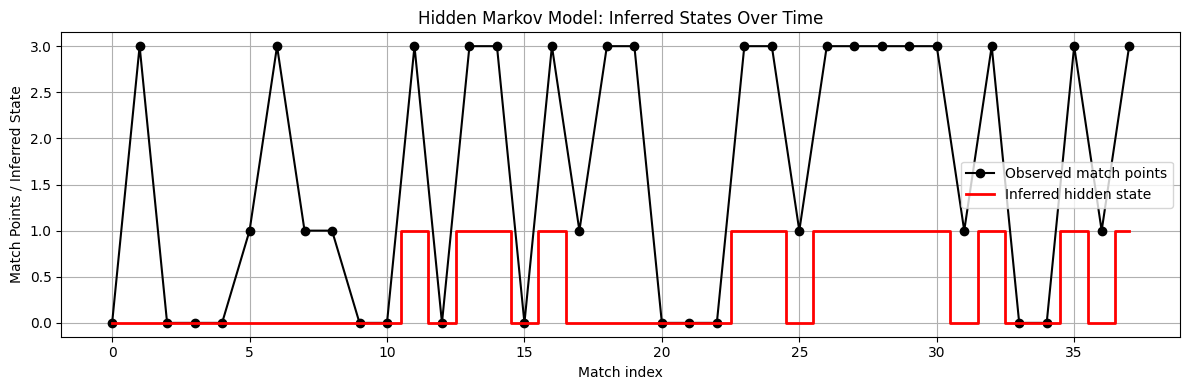

In [62]:
from scipy.stats import mode

# ---- STEP 3: Extract posterior modes of hidden states ----
inferred_states = []
for t in range(n):
    samples = trace.posterior[f"s_{t}"].values  # shape: (chains, draws)
    flat_samples = samples.flatten()
    most_common = mode(flat_samples, keepdims=False).mode
    inferred_states.append(most_common)

inferred_states = np.array(inferred_states)

# ---- STEP 4: Plot ----
plt.figure(figsize=(12, 4))
plt.plot(match_points, 'ko-', label="Observed match points")
plt.step(np.arange(n), inferred_states, where='mid', color='red', label="Inferred hidden state", linewidth=2)
plt.title("Hidden Markov Model: Inferred States Over Time")
plt.xlabel("Match index")
plt.ylabel("Match Points / Inferred State")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
az.summary(trace, var_names=["emission_probs"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"emission_probs[0, 0]",0.344,0.168,0.014,0.635,0.010,0.007,260.0,304.0,1.01
"emission_probs[0, 1]",0.217,0.144,0.001,0.476,0.010,0.007,202.0,619.0,1.01
"emission_probs[0, 2]",0.057,0.077,0.000,0.176,0.006,0.004,235.0,222.0,1.01
"emission_probs[0, 3]",0.381,0.201,0.000,0.687,0.018,0.013,132.0,479.0,1.01
"emission_probs[1, 0]",0.322,0.170,0.008,0.631,0.011,0.008,252.0,474.0,1.01
"emission_probs[1, 1]",0.201,0.148,0.002,0.471,0.010,0.007,218.0,504.0,1.01
"emission_probs[1, 2]",0.065,0.090,0.000,0.216,0.007,0.005,212.0,210.0,1.01
"emission_probs[1, 3]",0.413,0.206,0.001,0.712,0.019,0.013,134.0,425.0,1.01


### Calcultor

In [1]:
from stats_calculator import calculate_stats_per_match, get_available_teams

In [3]:
get_available_teams()

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brentford',
 'Brighton',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Ipswich Town',
 'Leicester City',
 'Liverpool',
 'Manchester City',
 'Manchester Utd',
 'Newcastle Utd',
 "Nott'ham Forest",
 'Southampton',
 'Tottenham',
 'West Ham',
 'Wolves']

In [4]:
point_per_match = calculate_stats_per_match("Arsenal", "points")
print(point_per_match)

[3, 3, 1, 3, 1, 3, 3, 0, 1, 0, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 0, 1, 1, 3, 3, 1, 1, 3, 1, 0, 1, 3, 3]


In [8]:
xg_per_match = calculate_stats_per_match("Arsenal", "xg")
print(xg_per_match)

[1.2, 0.9, 2.1, 0.7, 0.7, 4.4, 2.8, 0.7, 0.9, 1.1, 1.5, 1.2, 3.5, 2.1, 1.8, 1.2, 2.5, 1.8, 1.9, 0.9, 1.4, 1.3, 1.0, 1.0, 1.4, 1.2, 1.0, 1.6, 0.7, 2.2, 1.8, 1.0, 2.4, 1.2, 1.4, 2.6, 0.6, 2.3]


In [10]:
xga_per_match = calculate_stats_per_match("Arsenal", "xga")
print(xga_per_match)

[0.5, 1.2, 1.7, 0.7, 2.1, 0.3, 0.6, 1.8, 0.8, 0.5, 1.5, 0.3, 1.5, 0.2, 0.2, 0.1, 1.6, 0.2, 0.3, 1.5, 0.8, 1.0, 0.7, 0.8, 0.2, 1.1, 0.4, 1.5, 0.4, 1.0, 1.1, 0.2, 0.2, 1.7, 0.9, 2.4, 1.5, 0.6]


In [11]:
goals_for = calculate_stats_per_match("Arsenal", "xga")
print(xga_per_match)

[0.5, 1.2, 1.7, 0.7, 2.1, 0.3, 0.6, 1.8, 0.8, 0.5, 1.5, 0.3, 1.5, 0.2, 0.2, 0.1, 1.6, 0.2, 0.3, 1.5, 0.8, 1.0, 0.7, 0.8, 0.2, 1.1, 0.4, 1.5, 0.4, 1.0, 1.1, 0.2, 0.2, 1.7, 0.9, 2.4, 1.5, 0.6]


In [12]:
xga_per_match = calculate_stats_per_match("Arsenal", "xga")
print(xga_per_match)

[0.5, 1.2, 1.7, 0.7, 2.1, 0.3, 0.6, 1.8, 0.8, 0.5, 1.5, 0.3, 1.5, 0.2, 0.2, 0.1, 1.6, 0.2, 0.3, 1.5, 0.8, 1.0, 0.7, 0.8, 0.2, 1.1, 0.4, 1.5, 0.4, 1.0, 1.1, 0.2, 0.2, 1.7, 0.9, 2.4, 1.5, 0.6]


In [13]:
goals_against = calculate_stats_per_match("Arsenal", "goals_against")
print(goals_against)

[0, 0, 1, 0, 2, 2, 1, 2, 2, 1, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 2, 2, 2, 0, 1]


In [14]:
goals_for = calculate_stats_per_match("Arsenal", "goals_for")
print(goals_for)

[2, 2, 1, 1, 2, 4, 3, 0, 2, 0, 1, 3, 5, 2, 1, 0, 5, 1, 3, 1, 2, 2, 1, 5, 2, 0, 0, 1, 1, 2, 1, 1, 4, 2, 1, 2, 1, 2]


In [2]:
goal_diff = calculate_stats_per_match("Arsenal", "goal_difference")
print(goal_diff)

[2, 2, 0, 1, 0, 2, 2, -2, 0, -1, 0, 3, 3, 2, 0, 0, 4, 1, 2, 0, 1, 0, 1, 4, 2, -1, 0, 0, 1, 1, 0, 0, 4, 0, -1, 0, 1, 1]


In [2]:
xg_diff = calculate_stats_per_match("Arsenal", "xg_difference")
print(xg_diff)

[0.7, -0.3, 0.4, 0.0, -1.4, 4.1, 2.2, -1.1, 0.1, 0.6, 0.0, 0.9, 2.0, 1.9, 1.6, 1.1, 0.9, 1.6, 1.6, -0.6, 0.6, 0.3, 0.3, 0.2, 1.2, 0.1, 0.6, 0.1, 0.3, 1.2, 0.7, 0.8, 2.2, -0.5, 0.5, 0.2, -0.9, 1.7]
